In [3]:
import json
import os
from datetime import datetime
from collections import *
import pandas as pd
import numpy as np
import seaborn as sns
from dateutil import parser
from transformers import BertTokenizer,BertForSequenceClassification, BertConfig, AdamW
import torch
import torch.optim as optim
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import csv
import sys
sys.path.append('/home/kalkiek/projects/reddit-political-affiliation/')
from src.features.interactions.political_comment import PoliticalComment
import matplotlib.pyplot as plt

In [2]:
def read_in_bad_actors_from_tsv(in_files):
    bad_actors = defaultdict(list)

    for in_file in in_files:
        print("Reading in user politics from file: {}".format(in_file))
        with open(in_file, 'r',encoding="utf-8") as f:
            for line in f:
                user, politics, regex_match, subreddit, created, text = line.split('\t')
                entry = {'politics': politics, 'regex_match': regex_match, 'subreddit': subreddit,
                         'created': created,
                         'text': text}
                bad_actors[user].append(entry)

    return bad_actors

In [3]:
import praw

In [4]:
reddit = praw.Reddit(
    client_id="nBp23fzkdjk2Yw",
     client_secret="nwARwnHrGQXLC7zoYZoHVkx2tH_35g",
     user_agent="u/RevenueClassic330 did research by python script"
 )

In [3]:
bad_dir='/shared/0/projects/reddit-political-affiliation/data/bad-actors/gold/'
comments_dir=bad_dir+'comments/'

In [4]:
bad_actors = read_in_bad_actors_from_tsv(['/shared/0/projects/reddit-political-affiliation/data/bad-actors/gold/bad_actors.tsv'])
print("# of bad actors: {}".format(len(bad_actors)))

Reading in user politics from file: /shared/0/projects/reddit-political-affiliation/data/bad-actors/gold/bad_actors.tsv
# of bad actors: 7572


In [7]:
bad_actors['alphadeltaphi']

[{'politics': 'Republican',
  'regex_match': 'rep',
  'subreddit': 'canada',
  'created': '1275584890',
  'text': 'i vote conservative. canadian politicians are ineffectual at best, however, only a fiscal conservative is capable of running our socialist economy without recording massive debt in the process. i also only vote conservative because, as a native albertan i have seen the damage liberal governments have exacted on my province in the name of eastern votes.\n'},
 {'politics': 'Democrat',
  'regex_match': 'dem',
  'subreddit': 'canada',
  'created': '1275670055',
  'text': 'ignatieff reeks of the "liberal party entitlement" that killed the martin government. in his mind, "hey, i\'m a liberal! all i have to do is show up, act smug, smirk a bit and blow smoke up a few asses and i\'m in." i can forgive him a bit for not being effective as an opposition leader as doing so would force an election and therefore his hand, but still, quelle douche. a conservative majority would actually

In [5]:
dem_count=0
rep_count=0
close_count=0
very_divided_count=0
very_divided_list=[]
mainly_list=[]
divided_list=[]
gap=2/3
at_least=10
year_month_flip = Counter()
year_month_normal=Counter()
year_month_from_rep2dem=Counter()
year_month_from_dem2rep=Counter()
year_month_best_actor=Counter()
ratio=[]
total=[]
all_actor=[]
poli_counter=Counter()
flip_subreddit_counter=Counter()
best_actor_counter=Counter()
for key in bad_actors:
    information=bad_actors[key]
    time_list=[]
    dem_times=0
    rep_times=0
    for one_sent in information:
        poli_counter[one_sent['subreddit']]+=1
        if one_sent['politics']=='Democrat':
            dem_times+=1
        else:
            rep_times+=1
        first_pol_post_ts = int(one_sent['created'])
        first_post_date = datetime.fromtimestamp(first_pol_post_ts)
        year_month = str(first_post_date.year) + '-' + str(first_post_date.month)
        time_list.append(year_month)
        
    #print(dep_times,rep_times,time_list)
    #break
    ratio.append(dem_times/(dem_times+rep_times))
    total.append(dem_times+rep_times)
    all_actor.append(key)
    
    maj="Democrat" if dem_times>rep_times else "Republican"
    user_class=''
    if dem_times!=0 and rep_times!=0 and dem_times/rep_times>=gap and dem_times/rep_times<=1/gap:
        close_count+=1
        user_class='C'
        if dem_times>=at_least or rep_times>=at_least:
            very_divided_count+=1
            very_divided_list.append(key)
            print("Best Actor:",key,", Number of Dems:,",dem_times,", Number of Reps:",rep_times)
            user_class='V'
        else:
            divided_list.append(key)
            
        #print(dem_times,rep_times)
    elif maj=='Democrat':
        dem_count+=1 
        user_class='D'
        mainly_list.append(key)
    elif maj=='Republican':
        rep_count+=1
        user_class='R'
        mainly_list.append(key)
        
    for i in range(len(time_list)):
        year_month=time_list[i]
        #if (i!=0 and i!=len(time_list)-1 and times[i][0]!=times[i-1][0] and times[i][0]!=times[i+1][0]) or (i==len(time_list)-1 and times[i][0]!=times[i-1][0]):
        if information[i]['politics']!=maj:# and user_class!='V' and user_class!='C':
            year_month_flip[year_month]+=1
            flip_subreddit_counter[information[i]['subreddit']]+=1
            if information[i]['politics']=='Democrat':
                year_month_from_rep2dem[year_month]+=1
            else:
                year_month_from_dem2rep[year_month]+=1
        if user_class=='V':
            best_actor_counter[information[i]['subreddit']]+=1
            year_month_best_actor[year_month]+=1
        year_month_normal[year_month]+=1
print("Mainly dem users",dem_count)
print("Mainly rep users",rep_count)
print("Close users",close_count)
print("Very_divided",very_divided_count)
print(year_month_flip)

Best Actor: transcribot , Number of Dems:, 19 , Number of Reps: 19
Best Actor: Raindrops1984 , Number of Dems:, 11 , Number of Reps: 9
Best Actor: TrollaBot , Number of Dems:, 146 , Number of Reps: 139
Best Actor: TheGame81677 , Number of Dems:, 10 , Number of Reps: 10
Best Actor: headlineisBULLSHIT , Number of Dems:, 21 , Number of Reps: 14
Best Actor: Hank-the-Pigeon , Number of Dems:, 9 , Number of Reps: 11
Best Actor: ModerationLog , Number of Dems:, 15 , Number of Reps: 12
Best Actor: Motafication , Number of Dems:, 10 , Number of Reps: 13
Best Actor: EngiNERD1988 , Number of Dems:, 13 , Number of Reps: 16
Best Actor: CountryFriedBacon , Number of Dems:, 11 , Number of Reps: 12
Best Actor: Ronald-Hapchwarae , Number of Dems:, 15 , Number of Reps: 16
Best Actor: RobertJSparks , Number of Dems:, 12 , Number of Reps: 8
Best Actor: Piroko , Number of Dems:, 10 , Number of Reps: 13
Mainly dem users 2024
Mainly rep users 1655
Close users 3893
Very_divided 13
Counter({'2016-11': 411, '20

In [29]:
poli_df=pd.DataFrame(
    {'subreddit':list(poli_counter.keys()),
     'count':list(poli_counter.values())
    })
flip_df=pd.DataFrame(
    {'subreddit':list(flip_subreddit_counter.keys()),
     'count':list(flip_subreddit_counter.values())
    })
best_actor_df=pd.DataFrame(
    {'subreddit':list(best_actor_counter.keys()),
     'count':list(best_actor_counter.values())
    })

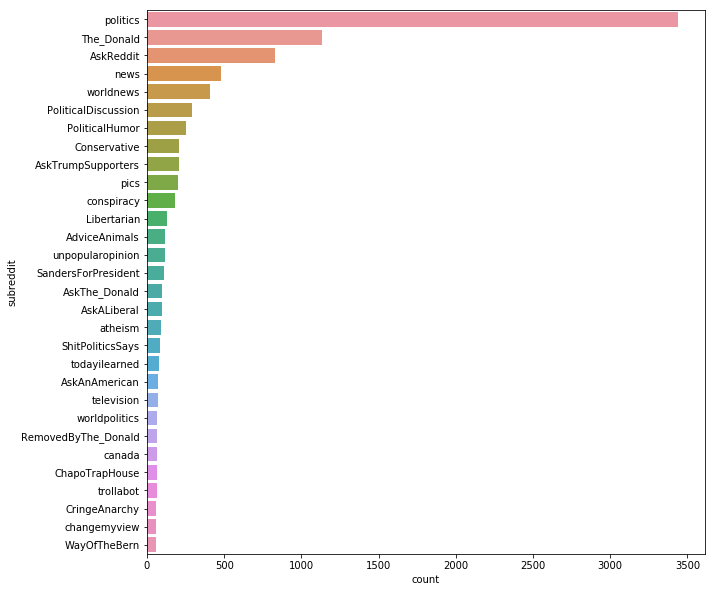

In [30]:
plt.figure(figsize=(10, 10))
sns.barplot(x="count", y="subreddit", data=poli_df.sort_values(by=['count'],ascending=False)[:30])

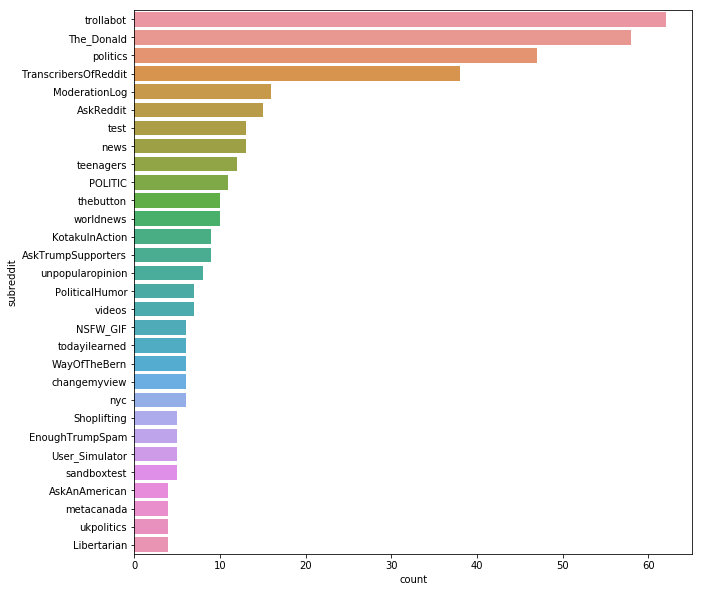

In [31]:
plt.figure(figsize=(10, 10))
sns.barplot(x="count", y="subreddit", data=best_actor_df.sort_values(by=['count'],ascending=False)[:30])

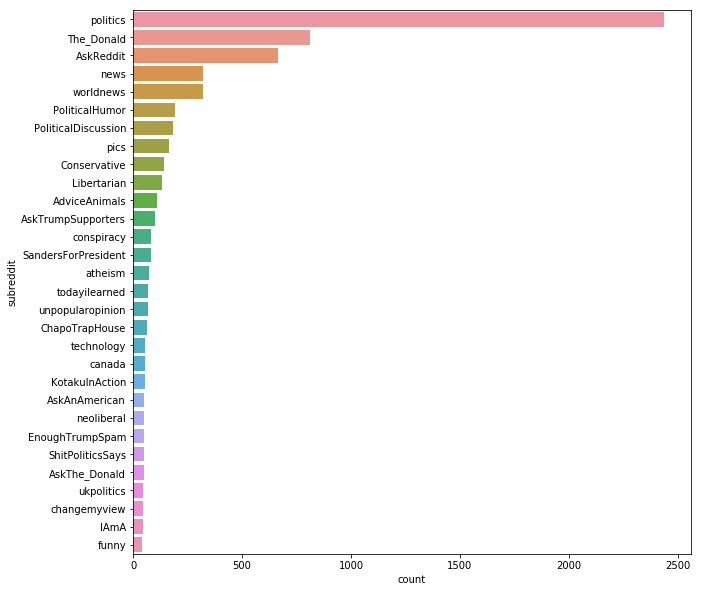

In [18]:
plt.figure(figsize=(10, 10))
sns.barplot(x="count", y="subreddit", data=flip_df.sort_values(by=['count'],ascending=False)[:30])

In [19]:
def check_status_of_user_list(very_divided_list):
    suspended_user_list=[]
    deleted_user_list=[]
    alive_user_list=[]
    indicate_list=[]
    for actor in very_divided_list:
        try:
            redditor = reddit.redditor(actor)
            if redditor.is_suspended:
                print("Actor",actor,"is suspended")
                suspended_user_list.append(actor)
                indicate_list.append(0)
        except:
            try:
                for comment in redditor.comments.new(limit=1):
                    a=1
                alive_user_list.append(actor)
                indicate_list.append(2)
                #print("Actor,",actor,"is alive")
            except:
                print("Actor",actor,"is deleted")
                deleted_user_list.append(actor)
                indicate_list.append(1)
    return suspended_user_list,deleted_user_list,alive_user_list,indicate_list

In [20]:
s,d,a,i=check_status_of_user_list(very_divided_list)
print("suspended:",len(s),"deleted:",len(d),"alive:",len(a))

Actor TrollaBot is deleted
Actor headlineisBULLSHIT is deleted
Actor Hank-the-Pigeon is suspended
Actor ModerationLog is suspended
Actor CountryFriedBacon is deleted
Actor Ronald-Hapchwarae is deleted
Actor Piroko is deleted
suspended: 2 deleted: 5 alive: 6


In [41]:
sa,da,aa,ia=check_status_of_user_list(all_actor)

Actor spinlock is suspended
Actor executex is suspended
Actor JohnnyBeagle is deleted
Actor outwrangle is deleted
Actor fett4evr is deleted
Actor folderol is suspended
Actor NoPantsBaby is deleted
Actor Xenomoly is deleted
Actor rveos773 is suspended
Actor michaelscottspenis is suspended
Actor PrancingPonyBarback is suspended
Actor DanFromREI is deleted
Actor BopTheDrass is deleted
Actor R_Gonemild is suspended
Actor Imadeadpeople is suspended
Actor Illnessofthenight is suspended
Actor showmeurboobsplznthx is deleted
Actor GreatSmithanon is suspended
Actor wigglebutt69 is deleted
Actor -Dantes_Inferno- is suspended
Actor Draestyn is deleted
Actor GiantRephaim is deleted
Actor IKilledYourBabyToday is suspended
Actor Quantcho is suspended
Actor 42turds is suspended
Actor Iamtheride is deleted
Actor zaparans is suspended
Actor FamburgerHelper is deleted
Actor ExcellentOdysseus is deleted
Actor its_a_tea_shop is suspended
Actor Nobody1796 is suspended
Actor budderboymania is suspended
Acto

Actor ClearLavishness is deleted
Actor LloydWoodsonJr is suspended
Actor Scrantonstrangla is suspended
Actor Sooomanytrolls is suspended
Actor ghost1738 is deleted
Actor uwagapies is suspended
Actor SquirrelTopTrump is suspended
Actor The_Next_Super_Being is deleted
Actor anewbirthoffreedom is deleted
Actor Tevo0617 is deleted
Actor byejerzy is deleted
Actor assassassandtitties is deleted
Actor Redpills4Pedes is suspended
Actor swattages is deleted
Actor oneUnit is suspended
Actor Wtf_isa_jesus is deleted
Actor Patriot4evr is deleted
Actor The420Sloth is suspended
Actor gavuroglu is deleted
Actor kshebdhdbr is suspended
Actor YoureSparePartsBud is deleted
Actor Reddit_is_dogshit is deleted
Actor Cymrukhan is deleted
Actor ElKukuy95 is deleted
Actor Aftunnels is deleted
Actor Bourbon_N_Bullets is suspended
Actor CarelessLine is deleted
Actor Mr_Beanths is suspended
Actor BillyBigBone is deleted
Actor EMStrauma is suspended
Actor SirKolbath is suspended
Actor Professional_PhD is deleted


Actor liseux is deleted
Actor PluresMentis is deleted
Actor Tortegamos is deleted
Actor fuzzydunlots is suspended
Actor TheGreatWhiteCiSHope is suspended
Actor dashnine is deleted
Actor jNathaniel is deleted
Actor HRpuffystuff is suspended
Actor TrumpCanada is suspended
Actor Miotoss is deleted
Actor Irondog1970 is deleted
Actor TidderGnillort is suspended
Actor ThePandagator is deleted
Actor SerenasHairyBalls is suspended
Actor L-I-A-R is suspended
Actor pjoneill15 is deleted
Actor House_Bitch is deleted
Actor Fancy_plumber is deleted
Actor MindYourGrindr is suspended
Actor Sqooge is suspended
Actor gingerspice999 is deleted
Actor BerningTendies is deleted
Actor Jkdsh is deleted
Actor AdventureFilm is deleted
Actor throwaway9765413 is deleted
Actor Tony_MarkMasters is deleted
Actor IronPathologist is deleted
Actor barawo33 is suspended
Actor MrPoopiButth0le is deleted
Actor flyingearthhuman is deleted
Actor Martaway is deleted
Actor ferrarifan is deleted
Actor AFuckYou is suspended
Ac

Actor liberationation is deleted
Actor BLACKMARQUETTE is suspended
Actor acecutty is deleted
Actor jakefromstatefarm10 is deleted
Actor TacoBenderz is deleted
Actor sleaze_bag_alert is suspended
Actor tholinz is deleted
Actor kittenwithadildo is suspended
Actor DAEFlair is deleted
Actor Mimetic_Apocalypse is deleted
Actor j_aubrey is deleted
Actor Armored_Fetus is deleted
Actor waxtats is deleted
Actor spaceman2121 is deleted
Actor inwonderment is deleted
Actor DrunkCaliban is deleted
Actor Alexlincoln2 is deleted
Actor Bokononism4Life is deleted
Actor PressedRat is deleted
Actor Chralemar is deleted
Actor ItsATedAndRandParty is deleted
Actor Cudder_Buddy is deleted
Actor antimarkovnikov is deleted
Actor SuperDanceParty is deleted
Actor WHBK is suspended
Actor teachingpigstosing is deleted
Actor ddmhughes is deleted
Actor vox_libertatis is deleted
Actor CanadianDragon434 is deleted
Actor nived321 is suspended
Actor FeelWhatIFeel is deleted
Actor pcarenza is deleted
Actor disposable182 

Actor Kacen is deleted
Actor TheInternetIsTheBest is deleted
Actor StevenBurnham is suspended
Actor hailredskinz is deleted
Actor ThatPerthFan is deleted
Actor IWantAKalashnikov is deleted
Actor ImHydeRightNow is deleted
Actor PostNationalism is suspended
Actor CanadianGreen is deleted
Actor fora-mejora is deleted
Actor acoustic4meplz88 is deleted
Actor trump_trizain is deleted
Actor pure_energy18 is deleted
Actor CorpseMachine is deleted
Actor nihiLSD is deleted
Actor coochmuncher69 is deleted
Actor HunterSTolkien is deleted
Actor ThisNameIsNotCeative is suspended
Actor SociopathicPeanut is suspended
Actor imd00m is deleted
Actor BeefCurtainsJohnson is deleted
Actor DirtyBristolBoi is suspended
Actor Bobby_3_Sticks is suspended
Actor imajustgo is deleted
Actor TheTruthStillMatters is suspended
Actor clydeskorner is deleted
Actor BlackRealist666 is suspended
Actor StealthModeWalking is suspended
Actor LarryDavidVEVO is deleted
Actor krisspykriss is deleted
Actor shadowcanned is suspend

In [69]:
print("Overall suspended:",len(sa),", Deleted:",len(da),",Alive:",len(aa))

Overall suspended: 378 , Deleted: 778 ,Alive: 3076


In [22]:
year_month_percentage=Counter()
for key in year_month_flip:
    year_month_percentage[key]=year_month_flip[key]/(year_month_normal[key] if year_month_normal[key]!=0 else float('inf'))

/opt/anaconda/lib/python3.6/site-packages/pandas/plotting/_matplotlib/converter.py:103: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


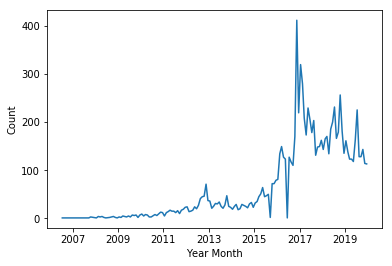

In [23]:
rows = []
for year_month, count in dict(year_month_flip).items():
    row = {'Year Month': parser.parse(year_month), 'Count': int(count)}
    rows.append(row)
    
flip_time = pd.DataFrame(rows)#flip_time
sns.lineplot(data=flip_time, x='Year Month', y='Count')

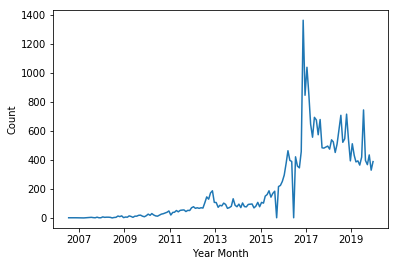

In [24]:
rows = []
for year_month, count in dict(year_month_normal).items():
    row = {'Year Month': parser.parse(year_month), 'Count': int(count)}
    rows.append(row)
    
normal_time = pd.DataFrame(rows)#flip_time
sns.lineplot(data=normal_time, x='Year Month', y='Count')

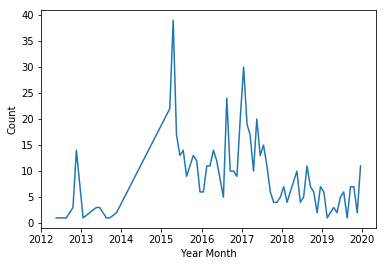

In [32]:
rows = []
for year_month, count in dict(year_month_best_actor).items():
    row = {'Year Month': parser.parse(year_month), 'Count': int(count)}
    rows.append(row)
    
best_actor_time = pd.DataFrame(rows)#flip_time
sns.lineplot(data=best_actor_time, x='Year Month', y='Count')

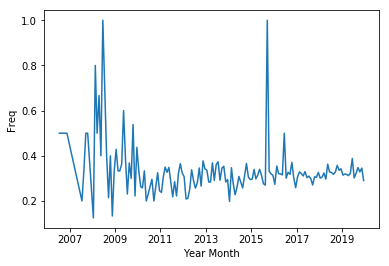

In [26]:
rows = []
for year_month, count in dict(year_month_percentage).items():
    row = {'Year Month': parser.parse(year_month), 'Freq': count}
    rows.append(row)
    
percentage_time = pd.DataFrame(rows)#flip_time
sns.lineplot(data=percentage_time, x='Year Month', y='Freq')

In [9]:
def prepare_features(seq_1, max_seq_length=128, zero_pad=True, include_CLS_token=True, include_SEP_token=True):
    # Tokenize Input
    tokens = tokenizer.tokenize(seq_1)[0:max_seq_length - 2]
    # Initialize Tokens
    if include_CLS_token:
        tokens.insert(0, tokenizer.cls_token)

    if include_SEP_token:
        tokens.append(tokenizer.sep_token)

    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    pad_id = tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0]
    # Input Mask
    input_mask = [1] * len(input_ids)
    # Zero-pad sequence length
    if zero_pad:
        while len(input_ids) < max_seq_length:
            input_ids.append(pad_id)
            input_mask.append(0)
    # print(torch.tensor(input_ids).shape)
    return torch.tensor(input_ids), torch.tensor(input_mask)

In [10]:
config = BertConfig.from_pretrained('bert-base-uncased')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification(config)
dv='cuda:1'
model.load_state_dict(torch.load("../interactions/best_bert.pt",map_location=torch.device(dv)))
device=torch.device(dv)
torch.cuda.set_device(int(dv[-1]))
model.cuda()
model.eval()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, element

In [1]:
def read_in_comments(in_file, count=-1):
    comments = []
    with open(in_file, 'r', encoding="utf-8") as f:
        for line in tqdm(f,total=count if count>0 else 137629803):
            line = line.strip()
            try:
                comment_id, parent_id, username, subreddit, created, politics, text = line.split('\t')
                political_comment = PoliticalComment(comment_id, parent_id, username, subreddit, created, politics,
                                                     text)
                comments.append(political_comment.to_dict())
                if count > 0 and len(comments) >= count:
                    print("Total number of political comments: {}".format(len(comments)))
                    return comments
            except Exception:
                pass

    print("Total number of political comments: {}".format(len(comments)))
    return comments

In [32]:
def calculate_offensive_bad_actors(bad_actor_data,output_files):
    with open(output_files, 'w',encoding="utf-8") as f:
        csvwriter = csv.writer(f,delimiter='\t') 
#         header=['user','politics','regex_match','subreddit','created','text','off_score']
#         csvwriter.writerow(header) 
        Y = []
        for idx, (comment_id, response) in tqdm(enumerate(bad_actor_data.iterrows()), total=len(bad_actor_data)):
            text_id, mask = prepare_features(response['text'])
            text_id = text_id.unsqueeze(0).cuda()
            mask = mask.unsqueeze(0).cuda()
            output = model.forward(text_id, attention_mask=mask)[0]
            soft_output = F.softmax(output, dim=1)
            Y.append(soft_output[0][1].item())
        bad_actor_data['toxicity']=Y
        bad_actor_data.to_csv(output_files, sep='\t')
            #rows=[key,response['politics'],response['regex_match'],response['subreddit'],response['created'],response['text'],soft_output[0][1].item()]
            #csvwriter.writerow(rows)

In [4]:
in_file = '/shared/0/projects/reddit-political-affiliation/data/interactions/all_comments_filtered.tsv'
comments = read_in_comments(in_file,count=1000000)
df_comments = pd.DataFrame(comments)

2000012it [00:08, 223436.07it/s]                            


Total number of political comments: 1000000


In [30]:
bad_actors_comments=df_comments[df_comments['username'].isin(bad_actors.keys())]
divided_actors_comments=df_comments[df_comments['username'].isin(very_divided_list)]

In [99]:
calculate_offensive_bad_actors(bad_actors_comments,'/shared/0/projects/reddit-political-affiliation/data/interactions_features/bad_actors_comments_with_off_score.tsv')

100%|██████████| 104836/104836 [29:09<00:00, 59.91it/s]
<ipython-input-98-d2c91b1e7762>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_actor_data['toxicity']=Y


In [33]:
calculate_offensive_bad_actors(divided_actors_comments,'/shared/0/projects/reddit-political-affiliation/data/interactions_features/divided_actors_comments_with_off_score.tsv')

100%|██████████| 267/267 [00:05<00:00, 50.99it/s]
<ipython-input-32-d2c91b1e7762>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bad_actor_data['toxicity']=Y


In [34]:
saved_path='/shared/0/projects/reddit-political-affiliation/data/interactions_features/bad_actors_comments_with_off_score.tsv'
bad_actors_toxicity_data = pd.read_csv(saved_path,sep='\t')
sum(bad_actors_toxicity_data['toxicity'].tolist())/len(bad_actors_toxicity_data)

0.3748996001760664

In [35]:
saved_path='/shared/0/projects/reddit-political-affiliation/data/interactions_features/divided_actors_comments_with_off_score.tsv'
divided_actors_toxicity_data = pd.read_csv(saved_path,sep='\t')
sum(divided_actors_toxicity_data['toxicity'].tolist())/len(divided_actors_toxicity_data)

0.42464285462480805

In [8]:
saved_path='/shared/0/projects/reddit-political-affiliation/data/interactions_features/all_interactions_feature.2.tsv'
all_toxicity_data = pd.read_csv(saved_path,sep='\t')
sum(all_toxicity_data['toxicity'].tolist())/len(all_toxicity_data)

0.34642265031951464

In [9]:
all_toxicity_data

,Unnamed: 0,Unnamed: 0.1,comment_id,parent_id,username,subreddit,created,politics,text,dyad,if_have_sensitive,if_have_affiliation,parent_toxicity,toxicity,FromPolitics,ToPolitics
0,0,70403,eyrog7s,eyrm42x,topcheesehead,funny,1567373953,Unknown,There will always be another asshole to stand ...,UnknowntoRepublican,0,0,0.945213,0.928402,Unknown,Republican
1,1,239292,eyx567y,eywd3kq,enterthewalrus,The_Donald,1567545042,Unknown,OMG they probably didn't say LMAO. Thanks for ...,UnknowntoDemocrat,0,0,0.158402,0.182919,Unknown,Democrat
2,2,839380,ezrzpuf,ezrg9c3,FakingItEveryDay,Anarcho_Capitalism,1568080909,Unknown,Can't have high blood sugar if you're starving...,UnknowntoRepublican,0,0,0.058271,0.148268,Unknown,Republican
3,3,933490,ezuxsn1,ezt5ca7,AllyPent,pokemongo,1568162926,Unknown,"You only can once a day battling team leaders,...",UnknowntoRepublican,0,0,0.791935,0.259930,Unknown,Republican
4,4,192317,eyvsada,eyve4ng,Aethersome,UNK,1567509792,Unknown,r/woooosh,UnknowntoDemocrat,0,0,0.103841,0.105061,Unknown,Democrat
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263591,263591,742744,ezmf3c7,ezmbncp,queen-adreena,worldnews,1567991016,Unknown,He’s not the type to ever risk his own neck ov...,UnknowntoDemocrat,0,0,0.306143,0.240554,Unknown,Democrat
263592,263592,315723,eyzbdz8,eyz9iza,MammothReindeer,worldnews,1567613887,Unknown,Lol dead civilians justify dead terrorists,UnknowntoRepublican,0,0,0.632035,0.660700,Unknown,Republican
263593,263593,922191,ezukhc4,ezujd01,dmkicksballs13,MMA,1568154338,Republican,Tony can be though is my point. People underes...,RepublicantoUnknown,0,0,0.805159,0.314630,Republican,Unknown
263594,263594,917419,ezuevan,eztzyba,auberus,UNK,1568150830,Democrat,No big deal. We'll be running discussions ever...,DemocrattoUnknown,0,0,0.116169,0.261166,Democrat,Unknown


In [14]:
count_bad=0
count_divide=0
actor_status=[]
for idx, (comment_id, response) in tqdm(enumerate(all_toxicity_data.iterrows()), total=len(all_toxicity_data)):
    if response['username'] in very_divided_list:
        actor_status.append('Divided_Actor')
        count_divide+=1
    elif response['username'] in bad_actors.keys():
        actor_status.append('Bad_Actor')
        count_bad+=1
    else:
        actor_status.append('Normal')
print(count_bad,count_divide)

100%|██████████| 263596/263596 [00:35<00:00, 7374.91it/s] 

12085 29


In [18]:
set(actor_status)

{'Bad_Actor', 'Divided_Actor', 'Normal'}

In [15]:
all_toxicity_data['Actor']=actor_status

In [16]:
all_toxicity_data

,Unnamed: 0,Unnamed: 0.1,comment_id,parent_id,username,subreddit,created,politics,text,dyad,if_have_sensitive,if_have_affiliation,parent_toxicity,toxicity,FromPolitics,ToPolitics,Actor
0,0,70403,eyrog7s,eyrm42x,topcheesehead,funny,1567373953,Unknown,There will always be another asshole to stand ...,UnknowntoRepublican,0,0,0.945213,0.928402,Unknown,Republican,Normal
1,1,239292,eyx567y,eywd3kq,enterthewalrus,The_Donald,1567545042,Unknown,OMG they probably didn't say LMAO. Thanks for ...,UnknowntoDemocrat,0,0,0.158402,0.182919,Unknown,Democrat,Normal
2,2,839380,ezrzpuf,ezrg9c3,FakingItEveryDay,Anarcho_Capitalism,1568080909,Unknown,Can't have high blood sugar if you're starving...,UnknowntoRepublican,0,0,0.058271,0.148268,Unknown,Republican,Normal
3,3,933490,ezuxsn1,ezt5ca7,AllyPent,pokemongo,1568162926,Unknown,"You only can once a day battling team leaders,...",UnknowntoRepublican,0,0,0.791935,0.259930,Unknown,Republican,Normal
4,4,192317,eyvsada,eyve4ng,Aethersome,UNK,1567509792,Unknown,r/woooosh,UnknowntoDemocrat,0,0,0.103841,0.105061,Unknown,Democrat,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
263591,263591,742744,ezmf3c7,ezmbncp,queen-adreena,worldnews,1567991016,Unknown,He’s not the type to ever risk his own neck ov...,UnknowntoDemocrat,0,0,0.306143,0.240554,Unknown,Democrat,Normal
263592,263592,315723,eyzbdz8,eyz9iza,MammothReindeer,worldnews,1567613887,Unknown,Lol dead civilians justify dead terrorists,UnknowntoRepublican,0,0,0.632035,0.660700,Unknown,Republican,Normal
263593,263593,922191,ezukhc4,ezujd01,dmkicksballs13,MMA,1568154338,Republican,Tony can be though is my point. People underes...,RepublicantoUnknown,0,0,0.805159,0.314630,Republican,Unknown,Normal
263594,263594,917419,ezuevan,eztzyba,auberus,UNK,1568150830,Democrat,No big deal. We'll be running discussions ever...,DemocrattoUnknown,0,0,0.116169,0.261166,Democrat,Unknown,Normal


In [17]:
all_toxicity_data.to_csv('/shared/0/projects/reddit-political-affiliation/data/interactions_features/all_interactions_feature.3.tsv', sep='\t')